# Preparations

In [1]:
import sys
import math
import numpy as np

%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt

sys.path.append('..')
from higgs_inference import settings

In [2]:
colors = ['C' + str(i) for i in range(10)]

# Data for baseline

In [28]:
metrics_filenames = ['logr', 'logr_trimmed', 'ce', 'ce_trimmed', 'scores', 'scores_trimmed']
metrics_labels = [r'MSE $\log \ r$', r'MSE $\log \ r$ (trimmed)', 'Cross entropy', 'Cross entropy (trimmed)', 'MSE scores', 'MSE scores (trimmed)']
n_metrics = len(metrics_filenames)
metrics_min = [0., 0., 0.657, 0.657, 0., 0.]
metrics_max = [0.18, 0.18, 0.675, 0.675, 3.5, 3.5]

strategies_filenames = ['carl', #'combined', 'regression', 'combinedregression',
                        'carl_smeared', 'combined_smeared', 'regression_smeared','combinedregression_smeared']
strategies_folders = ['parameterized'] * len(strategies_filenames)
strategies_labels = ['carl', #'carl + score', 'ratio regression', 'ratio regr. + score',
                     'carl', 'carl + score', 'ratio regression', 'ratio regr. + score']
strategies_panel = [0, #0, 0, 0,
                    1, 1, 1, 1]
n_panels = max(strategies_panel) + 1


In [29]:
metrics = []  # Indexed by [strategy][metric][train/validation][epoch]
detailed_metrics = []  # Indexed by [strategy][metric][batch] (only available on train)
result_dir = '../results'

for sfile, sfolder in zip(strategies_filenames, strategies_folders):
    line1 = []
    line2 = []
    for met in metrics_filenames:
        line1.append(np.load(result_dir + '/' + sfolder + '/traininghistory_' + met + '_' + sfile + '.npy') )
        line2.append(np.load(result_dir + '/' + sfolder + '/detailedtraininghistory_' + met + '_' + sfile + '.npy') )
    metrics.append(line1)
    detailed_metrics.append(line2)
    

In [30]:
n_batches_per_block = 10000
coarsegrained_detailed_metrics = []

for strategy_results in detailed_metrics:
    
    coarsegrained_strategy_results = []
    
    for metric_results in strategy_results:
        
        coarsegrained_metric_results = []
        
        n_batches = len(metric_results)

        lower = - n_batches_per_block
        upper = 0

        while upper < n_batches:
            lower += n_batches_per_block
            upper += n_batches_per_block
            coarsegrained_metric_results.append(np.mean(metric_results[lower:upper]))
            
        coarsegrained_metric_results = np.asarray(coarsegrained_metric_results)
        coarsegrained_strategy_results.append(coarsegrained_metric_results)
        
    coarsegrained_detailed_metrics.append(coarsegrained_strategy_results)
        

# Baseline results

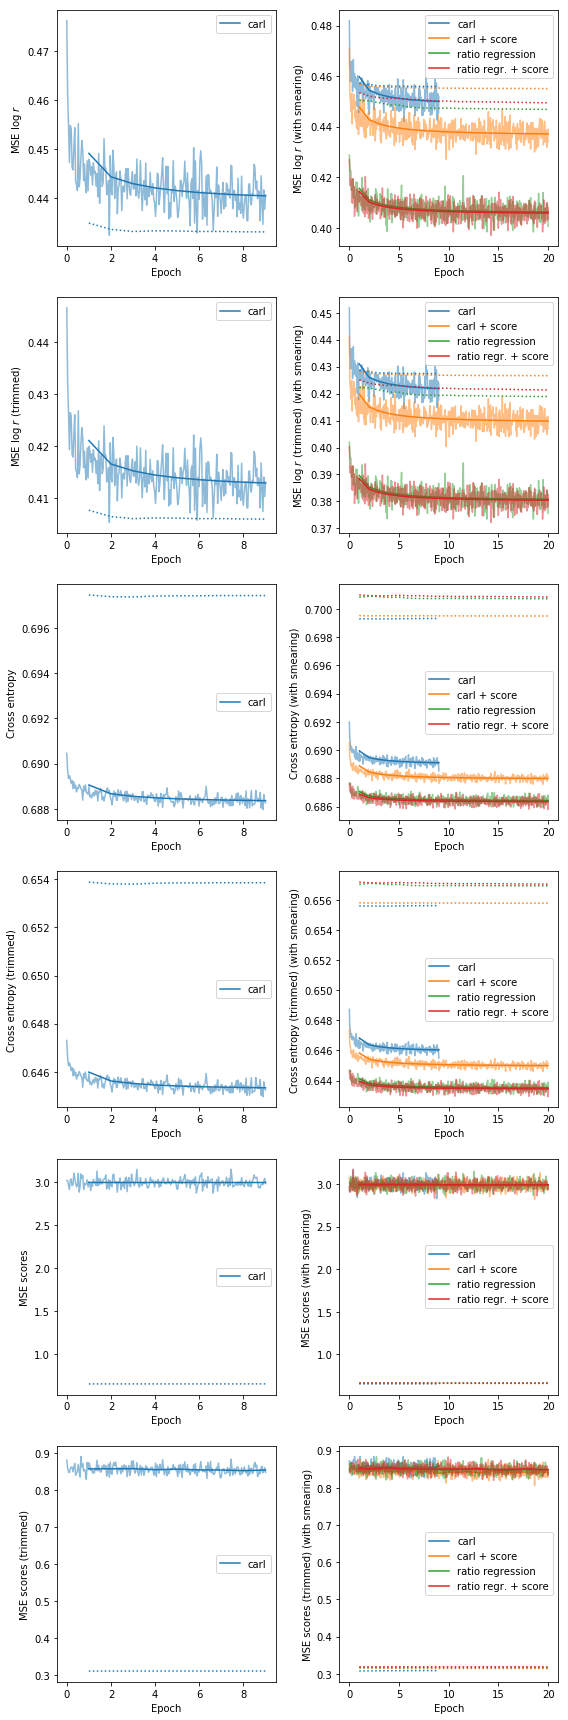

In [27]:
plt.figure(figsize=(n_panels*4., n_metrics*4))

for p in range(n_panels):

    for m, mlabel in enumerate(metrics_labels):
        
        plt.subplot(n_metrics, n_panels, m * n_panels + p + 1)
        i = 0
        
        for s, (spanel, slabel) in enumerate(zip(strategies_panel, strategies_labels)):
            if spanel != p:
                continue
                
            n_epochs = len(metrics[s][m][0])
            n_batches = len(coarsegrained_detailed_metrics[s][m])
                
            # Per-batch training data
            _y = coarsegrained_detailed_metrics[s][m]
            _x = np.linspace(0., n_epochs, n_batches)
            plt.plot(_x, _y, c=colors[i], ls='-', alpha=0.5)
                
            # Training data
            _y = metrics[s][m][0]
            _x = np.linspace(1., n_epochs, n_epochs)
            plt.plot(_x, _y, c=colors[i], ls='-', label=slabel)

            # Validation set
            _y = metrics[s][m][1]
            _x = np.array(list(range(len(_y)))) + 1
            plt.plot(_x, _y, c=colors[i], ls=':')
            
            i += 1
        
        plt.legend()
        
        #plt.ylim(metrics_min[m],metrics_max[m])
        #plt.xlim(-0.1,20.1)
        
        plt.xlabel('Epoch')
        if p == 0:
            plt.ylabel(mlabel)
        else:
            plt.ylabel(mlabel + ' (with smearing)')

plt.tight_layout()
plt.savefig('../figures/learning_curves/learning_curves_baseline.pdf')